<a href="https://colab.research.google.com/github/TrzeciakPiotr2300/Learning-Recommender_Systems/blob/main/HW03_knn_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def user_sim_matrix(ui_matrix, min_common_items=5):
    """
    Calculate the cosine similarity matrix between all users
    Upper triangle only - lower triangle remains zeros
    Only considers items rated by both users

    Args:
        ui_matrix: pandas DataFrame, user-item matrix with users as rows and items as columns
        min_common_items: minimum number of items rated by both users to calculate similarity

    Returns:
        pandas DataFrame, cosine similarity matrix with same indices as input matrix
    """
    # Get users
    users = ui_matrix.index.tolist()
    n = len(users)

    # Create empty similarity matrix with appropriate indices
    csm = pd.DataFrame(np.zeros((n, n)), index=users, columns=users)

    # Calculate cosine similarity - upper triangle only
    for i, user1 in enumerate(users):
        # Print progress indicator for large datasets
        if i % 100 == 0 and i > 0:
            print(f"Processing user {i} of {n}")

        user1_ratings = ui_matrix.loc[user1]

        # Items rated by user1 (non-zero ratings)
        user1_rated_items = user1_ratings[user1_ratings > 0].index.tolist()

        # Calculate only for upper triangle (j >= i)
        for j, user2 in enumerate(users[i:], i):
            if user1 == user2:
                # Self-similarity is 1
                csm.loc[user1, user2] = 1.0
                continue

            user2_ratings = ui_matrix.loc[user2]

            # Items rated by user2 (non-zero ratings)
            user2_rated_items = user2_ratings[user2_ratings > 0].index.tolist()

            # Find common items rated by both users
            common_items = list(set(user1_rated_items) & set(user2_rated_items))

            # Skip if not enough common items
            if len(common_items) < min_common_items:
                csm.loc[user1, user2] = 0
                continue

            # Get ratings for common items
            user1_common_ratings = ui_matrix.loc[user1, common_items].values
            user2_common_ratings = ui_matrix.loc[user2, common_items].values

            # Calculate norms for the common item vectors
            norm1 = np.sqrt(np.sum(user1_common_ratings ** 2))
            norm2 = np.sqrt(np.sum(user2_common_ratings ** 2))

            # Avoid division by zero
            if norm1 == 0 or norm2 == 0:
                sim = 0
            else:
                # Calculate dot product for common items only
                dot_product = np.dot(user1_common_ratings, user2_common_ratings)
                sim = dot_product / (norm1 * norm2)

            # Fill only the upper triangle cell
            csm.loc[user1, user2] = sim

    return csm

In [ ]:
# Here I define a function that returns k nearest neighbours to given user
def k_neighbours(active_user, k, similarity_matrix):
    """
    Returns the IDs of K nearest neighbors of the active user based on similarity_matrix

    Args:
        active_user: user ID for whom we find neighbors
        k: number of nearest neighbors to return
        similarity_matrix: DataFrame, similarity matrix where indices are user IDs

    Returns:
        list of user IDs of the K nearest neighbors
    """
    # Get active user's row and column (users with higher IDs)
    row_similarities = similarity_matrix.loc[active_user].copy()
    col_similarities = similarity_matrix[active_user].copy()

    # Combine them, keeping the highest similarity values
    all_similarities = pd.Series(index=similarity_matrix.index)

    for user in all_similarities.index:
        if user == active_user:
            all_similarities[user] = 0  # Skip self
        elif user > active_user:  # Check row
            all_similarities[user] = row_similarities[user]
        else:  # Check column
            all_similarities[user] = col_similarities[user]

    # Sort by similarity in descending order
    sorted_neighbours = all_similarities.sort_values(ascending=False)

    # Return the top k user IDs
    return sorted_neighbours.index[:k].tolist()

In [ ]:
def k_neighbours_who_rated(active_user, k, similarity_matrix, item_id, user_item_matrix):
    """
    Returns the IDs of K nearest neighbors who have rated a specific item

    Args:
        active_user: user ID for whom we find neighbors
        k: number of nearest neighbors to return
        similarity_matrix: DataFrame, similarity matrix where indices are user IDs
        item_id: ID of the item that neighbors must have rated
        user_item_matrix: user-item matrix

    Returns:
        list of user IDs of the K nearest neighbors who rated the item
    """
# changes down
    # Check if item exists in the matrix
    if item_id not in user_item_matrix.columns:
        return []

    # Get all users who have rated the item
    try:
        users_who_rated = user_item_matrix[user_item_matrix[item_id] > 0].index.tolist()
    except KeyError:
        return []
# changes up #

    # Rest of the function stays the same...
    # Get all users who have rated the item
    #users_who_rated = user_item_matrix[user_item_matrix[item_id] > 0].index.tolist()

    # Get all similarities, combining row and column
    row_similarities = similarity_matrix.loc[active_user].copy()
    col_similarities = similarity_matrix[active_user].copy()

    all_similarities = pd.Series(index=similarity_matrix.index)
    for user in all_similarities.index:
        if user == active_user:
            all_similarities[user] = 0  # Skip self
        elif user > active_user:  # Check row
            all_similarities[user] = row_similarities[user]
        else:  # Check column
            all_similarities[user] = col_similarities[user]

    # Filter to include only users who rated the item and exclude active user
    filtered_similarities = all_similarities.loc[users_who_rated]
    if active_user in filtered_similarities.index:
        filtered_similarities = filtered_similarities.drop(active_user)

    # Sort by similarity in descending order
    sorted_neighbours = filtered_similarities.sort_values(ascending=False)

    # Return the top k user IDs
    return sorted_neighbours.index[:k].tolist()

In [ ]:
# Now I try to implement the rating system (predictions)
# It is weighted sum
def predict_rating(active_user, item_id, user_item_matrix, similarity_matrix, k=10, treshold=0.1, min_votes=3):
    """
    Predict the rating an active user would give to an item using KNN

    Args:
        active_user: user ID for whom we predict the rating
        item_id: item ID for which we predict the rating
        user_item_matrix: user-item matrix
        similarity_matrix: similarity matrix
        k: number of nearest neighbors to consider
        min_votes: minimum number of votes required

    Returns:
        float: predicted rating or None if prediction can't be made
    """
# changes down #
    # Check if user exists in the matrix
    if active_user not in user_item_matrix.index:
        return None

    # Check if item exists in the matrix
    if item_id not in user_item_matrix.columns:
        return None

    # Check if user has already rated the item
    try:
        if user_item_matrix.loc[active_user, item_id] > 0:
            return user_item_matrix.loc[active_user, item_id]
    except (KeyError, ValueError):
        return None
# Changes up #
    # Check if user has already rated the item
    # if user_item_matrix.loc[active_user, item_id] > 0:
    #     return user_item_matrix.loc[active_user, item_id]

    # Get k nearest neighbors
    neighbors = k_neighbours(active_user, k, similarity_matrix)

    # Filter to neighbors who rated the item
    neighbors_who_rated = [n for n in neighbors if user_item_matrix.loc[n, item_id] > 0]

    # If not enough neighbors rated the item, get additional neighbors who did rate it
    if len(neighbors_who_rated) < min_votes:
        additional_neighbors = k_neighbours_who_rated(
            active_user,
            min_votes - len(neighbors_who_rated),
            similarity_matrix,
            item_id,
            user_item_matrix
        )
        neighbors_who_rated.extend([n for n in additional_neighbors if n not in neighbors_who_rated])

    # If still not enough neighbors, return None
    if len(neighbors_who_rated) < min_votes:
        return None

    # Calculate weighted average of ratings (can be changed to majority voting)
    weighted_sum = 0
    similarity_sum = 0

    for neighbor in neighbors_who_rated:
        # Get similarity, checking both row and column as needed
        if neighbor > active_user:
            similarity = similarity_matrix.loc[active_user, neighbor]
        else:
            similarity = similarity_matrix.loc[neighbor, active_user]

        rating = user_item_matrix.loc[neighbor, item_id]

        weighted_sum += similarity * rating
        similarity_sum += abs(similarity)

    # Avoid division by zero
    if similarity_sum == 0:
        return None

    score = weighted_sum / similarity_sum
    # Return weighted average (can be rounded up to closest integer number if needed)
    if score - np.floor(score) < treshold:
        return int(np.floor(score))
    else:
        return int(np.ceil(score))

In [ ]:
##########                                 ##########
##########   Now we will do our homework   ##########
##########                                 ##########

In [ ]:
import pandas as pd
import numpy as np

#u.data
file_path = "ml-100k/u.data"
column_names = ["user_id", "item_id", "rating", "timestamp"]
u_data = pd.read_csv(file_path, sep="\t", names=column_names, header=None)

#u.item
file_path = "ml-100k/u.item"
column_names = [
    "movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL",
    "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
    "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",
    "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
u_item = pd.read_csv(file_path, sep="|", names=column_names, encoding="latin-1", header=None)

#u.info
file_path = "ml-100k/u.info"
with open(file_path, "r") as file:
    info = file.readlines()
num_users = int(info[0].split()[0])
num_items = int(info[1].split()[0])
num_ratings = int(info[2].split()[0])
print(f"Number of users: {num_users}")
print(f"Number of films: {num_items}")
print(f"Number of ratings: {num_ratings}")
print(f"u_data shape: {u_data.shape}")
print(u_data.columns.values)

Number of users: 943
Number of films: 1682
Number of ratings: 100000
u_data shape: (100000, 4)
['user_id' 'item_id' 'rating' 'timestamp']


In [ ]:
# Spliting data to train/validation/test - 60/20/20
np.random.seed(100)
indices = np.random.permutation(u_data.shape[0])
train_ind = indices[:int(len(indices) * 0.6)]
validation_ind = indices[int(len(indices) * 0.6) : int(len(indices) * 0.8)]
test_ind = indices[int(len(indices) * 0.8) : ]
u_train, u_validation, u_test = u_data.iloc[train_ind,:], u_data.iloc[validation_ind,:], u_data.iloc[test_ind,:]

In [ ]:
# user_item_matrix_train = u_train.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
# user_item_matrix_train.to_csv('data/user_item_matrix_train.csv', index=False)

# similarity_matrix_train = user_sim_matrix(user_item_matrix_train)
#similarity_matrix_train.to_csv("data/similarity_matrix_train.csv", index=True, header=True)

ui_matrix_train_full = pd.read_csv('data/user_item_matrix_train.csv')
ui_matrix_train_full.index = range(1, len(ui_matrix_train_full) + 1)  # Assuming user_ids start from 1
ui_matrix_train_full.columns = [int(col) for col in ui_matrix_train_full.columns]

sim_matrix_train_full = pd.read_csv('data/similarity_matrix_train.csv', index_col=0)
sim_matrix_train_full.index = [int(idx) for idx in sim_matrix_train_full.index]
sim_matrix_train_full.columns = [int(col) for col in sim_matrix_train_full.columns]

In [ ]:
print(predict_rating(5, 600, ui_matrix_train_full, sim_matrix_train_full, k=10, treshold=0.1, min_votes=3))

None


In [ ]:
"""
in order to find optimal k, we'll search through all possible k's.
but we may stick to POSSIBE k's, meaning that first we'll find maximum amount of neighbours X
and well take min(X, 50) to be the range of k_values to search
"""
# Meaby later :)

"\nin order to find optimal k, we'll search through all possible k's.\nbut we may stick to POSSIBE k's, meaning that first we'll find maximum amount of neighbours X \nand well take min(X, 50) to be the range of k_values to search\n"

In [ ]:
# Pradicting rating for u_validation matrix for different k'
#initialising
k_values = np.arange(1, 11)
k_fit = 0

n = u_validation.shape[0]
accuracy = 0 #initialize
right = 0
total = n

df_accuracy = pd.DataFrame({
    'k': k_values,
    'accuracy': np.nan
})

In [ ]:
## Calculations ##
# for (i,k) in enumerate(k_values):
#     print(f"k = {k}")
#     right = 0
#     for row in range(n):
#         user_id = u_validation['user_id'].iloc[row]
#         item_id = u_validation['item_id'].iloc[row]
#         rating  = u_validation['rating'].iloc[row]
#         if predict_rating(user_id, item_id, ui_matrix_train_full, sim_matrix_train_full, k) == rating:
#             right += 1
#         if (row % 10000 == 0 and row > 0):
#             print(f'{row} out of {n}')
#             print(f'current accuracy = {right / row}')
#             print(f'cumulativ accuracy = {right / n}')

#     df_accuracy.loc[i, 'accuracy'] = right / total

#     if right / total > accuracy:
#         k_fit = k
#         accuracy = right / total

#     print(f"accuracy of {i}: {df_accuracy['accuracy'].iloc[i]}")
df_accuracy.dropna(inplace=True)
#df_accuracy_copy = df_accuracy
df_accuracy_copy.to_csv("data/k_comparison.csv", index=False)

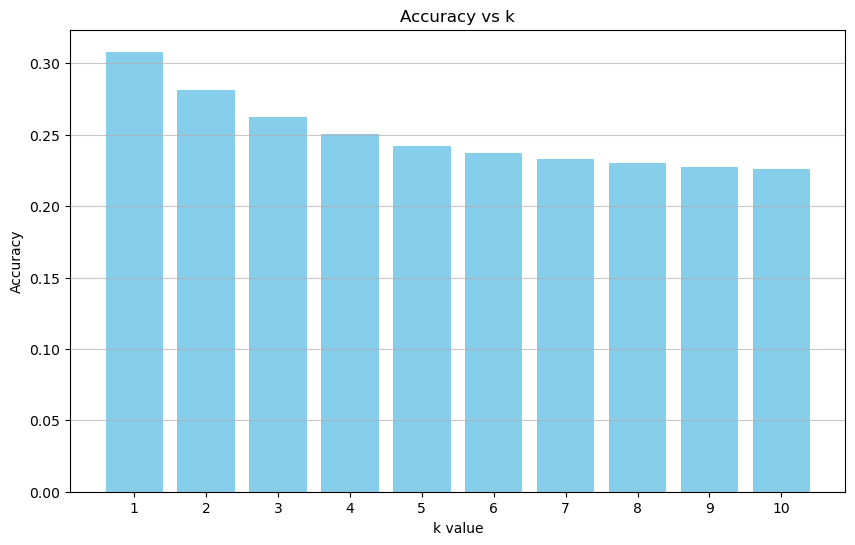

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(df_accuracy['k'], df_accuracy['accuracy'], color='skyblue')
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')
plt.xticks(df_accuracy['k'])  # żeby każdy k był na osi X
plt.grid(axis='y', alpha=0.7)
plt.show()

In [ ]:
def RMSE(y_pred, y_test):
    if len(y_pred) != len(y_test):
        return None
    else:
        mse = np.mean((y_test - y_pred) ** 2)
        return np.sqrt(mse)

def MAE(y_pred, y_test):
    if len(y_pred) != len(y_test):
        return None
    else:
        return np.mean(np.abs(y_pred - y_test))

def R_squared(y_pred, y_test):
    if len(y_pred) != len(y_test):
        return None
    else:
        y_dash = np.mean(y_test)
        return 1 - (y_pred - y_test) ** 2 / (y_pred - y_dash) ** 2
